In [25]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [26]:
%matplotlib inline

In [27]:
sns.set()

In [28]:
name = 'josh'
date = datetime(2019,3,17)
filename = '{}_{}.pkl'.format(name,date.strftime('%d%b%y'))
filename

'josh_17Mar19.pkl'

In [29]:
data = pd.read_pickle('processed_data/'+filename)


In [30]:
data.reset_index(drop=True,inplace=True)

In [31]:
data.head()

,Date,Time,Lat,Lon,GPS_Alt,Pressure,Pres_Alt,Temp,Batt,Lat_Rad,Lon_Rad,Lat_Delta,Lon_Delta,Lat_Rad_Delta,Lon_Rad_Delta,GPS_Alt_Delta,distance,gradient,grad_colour
0,03/17/2019,08:44:03,45.097191,6.069313,0.0,11002221010,1859.802,23.4,4.022,0.787094,0.105930,0.000000,-0.000001,0.000000e+00,-2.617994e-08,NaN,0.117777,NaN,2
1,03/17/2019,08:44:04,45.097191,6.069315,1867.0,11002221022,1860.903,23.4,3.945,0.787094,0.105930,0.000000,0.000006,0.000000e+00,1.012291e-07,1867.0,0.455403,0.013976,1
2,03/17/2019,08:44:05,45.097191,6.069309,1867.1,11002221000,1860.602,23.4,3.925,0.787094,0.105929,-0.000004,0.000008,-6.981317e-08,1.326450e-07,0.1,0.744343,82.348319,0
3,03/17/2019,08:44:06,45.097195,6.069302,1867.2,11002221021,1859.802,23.5,3.938,0.787095,0.105929,0.000000,0.000008,0.000000e+00,1.413717e-07,0.1,0.635994,81.064310,0
4,03/17/2019,08:44:07,45.097195,6.069293,1867.0,11002221100,1860.703,23.5,3.938,0.787095,0.105929,0.000000,0.000007,0.000000e+00,1.169371e-07,-0.2,0.526069,-69.184302,2


In [32]:
data['gps_alt_roll']=data.GPS_Alt.rolling(400).mean()

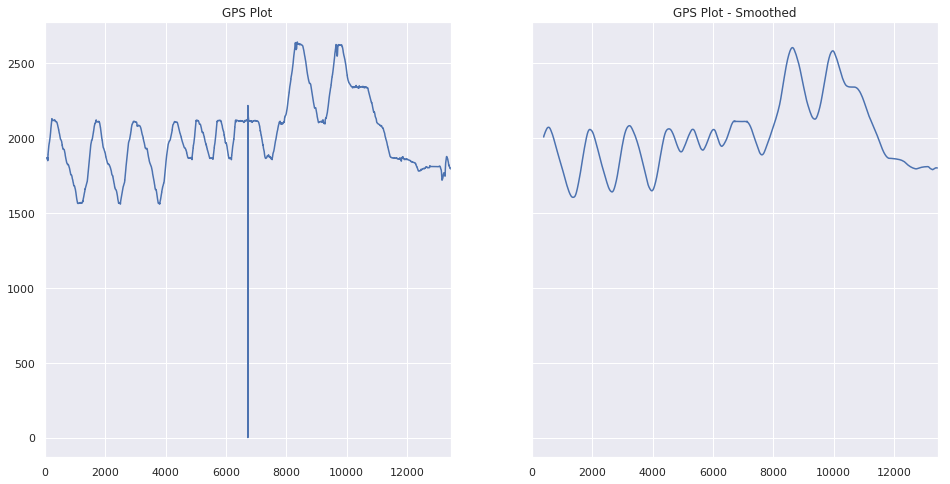

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,8))
data.GPS_Alt.plot(ax=ax1,title='GPS Plot')
data.gps_alt_roll.plot(ax=ax2,title='GPS Plot - Smoothed')


In [34]:
data['gps_alt_roll_delta'] = data.gps_alt_roll[:-1] - data.gps_alt_roll[1:].values
data['gps_alt_raw_delta'] = data.GPS_Alt[:-1] - data.GPS_Alt[1:].values

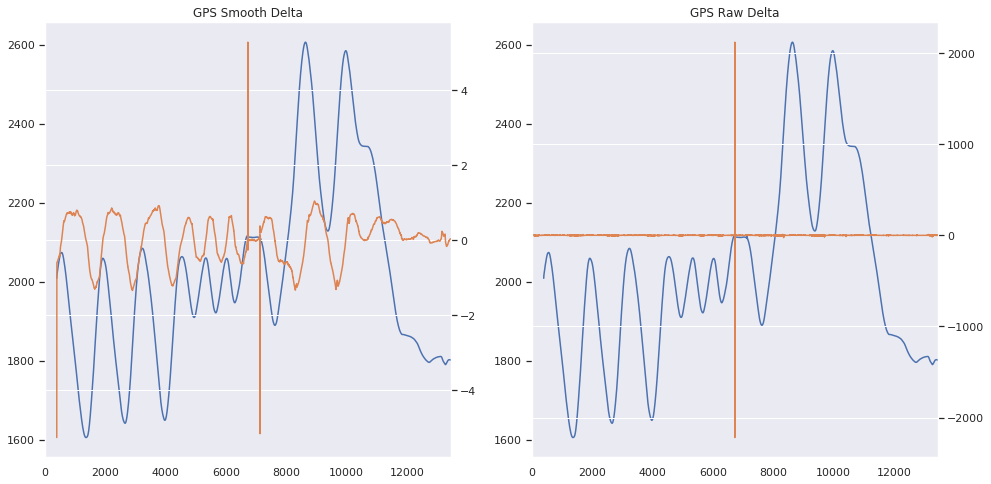

In [35]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))
data.gps_alt_roll.plot(ax=ax[0],title='GPS Smooth Delta')
data.gps_alt_roll_delta.plot(ax=ax[0],secondary_y=True)
data.gps_alt_roll.plot(ax=ax[1],title='GPS Raw Delta')
data.gps_alt_raw_delta.plot(ax=ax[1],secondary_y=True)

In [36]:
#data['gps_alt_roll_delta_roll_delta'] = data.gps_alt_roll_delta_roll[:-1] - data.gps_alt_roll_delta_roll[1:].values
#data['gps_alt_roll_delta_roll_delta_roll'] =data.gps_alt_roll_delta_roll_delta.rolling(240).mean()

#data['gps_alt_raw_delta_roll_delta'] = data.gps_alt_raw_delta_roll[:-1] - data.gps_alt_raw_delta_roll[1:].values
#data['gps_alt_raw_delta_roll_delta_roll'] =data.gps_alt_raw_delta_roll_delta.rolling(240).mean()

data['gps_alt_raw_delta_roll'] =data.gps_alt_raw_delta.rolling(180).mean()
data['gps_alt_roll_delta_roll'] =data.gps_alt_roll_delta.rolling(180).mean()

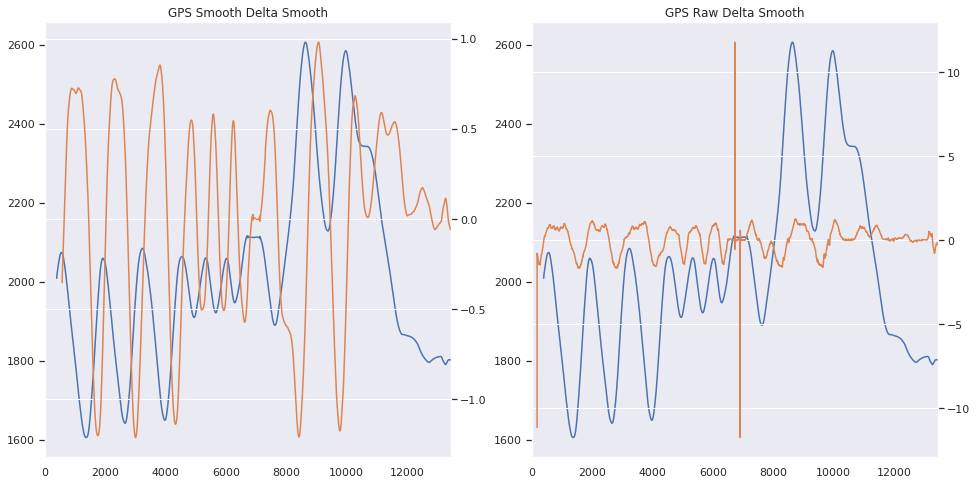

In [37]:
fig, ax= plt.subplots(1, 2, figsize=(16,8))
data.gps_alt_roll.plot(ax=ax[0],title='GPS Smooth Delta Smooth')
data.gps_alt_roll_delta_roll.plot(ax=ax[0],secondary_y=True)
data.gps_alt_roll.plot(ax=ax[1],title='GPS Raw Delta Smooth')
data.gps_alt_raw_delta_roll.plot(ax=ax[1],secondary_y=True)

In [38]:
signs = np.sign(data.gps_alt_raw_delta_roll.fillna(0))
signchange = ((np.roll(signs, 1) - signs) != 0).astype(int)

In [39]:
sign_changes_idx = signchange.index[signchange == 1].tolist()

In [40]:
routes_list=[]
for i in range(len(sign_changes_idx)-1):
    #print(sign_changes_idx[i],sign_changes_idx[i+1]-1, signs[sign_changes_idx[i]])
    start = sign_changes_idx[i]
    end = sign_changes_idx[i+1]-1
    sign = signs[sign_changes_idx[i]]
    max_val = np.max(data.loc[start:end,('gps_alt_raw_delta_roll')])
    routes_list.append((start,end,sign,max_val ))
    
routes = pd.DataFrame(routes_list,columns=['start_idx','end_idx','sign','peak'])
routes.head()

,start_idx,end_idx,sign,peak
0,179,403,-1.0,-0.004444
1,404,1257,1.0,0.967778
2,1258,1828,-1.0,-0.003889
3,1829,2563,1.0,1.107778
4,2564,2564,0.0,0.000000


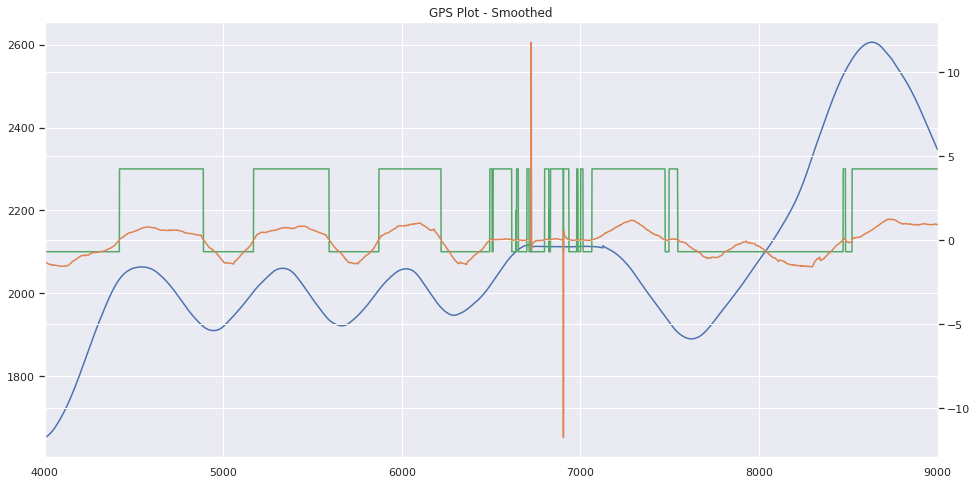

In [41]:
small_data =data.loc[4000:9000]
small_signs = signs.loc[4000:9000] *100 +2200
fig, ax= plt.subplots(1, 1, figsize=(16,8))
small_data.gps_alt_roll.plot(ax=ax,title='GPS Plot - Smoothed')
small_data.gps_alt_raw_delta_roll.plot(ax=ax,secondary_y=True)
small_signs.plot(ax=ax)

In [42]:
peak_filter = 0.5
runs = routes[(routes.sign== 1) & (routes.peak >= peak_filter)].copy()
runs.reset_index(inplace=True)
num_runs = runs.shape[0]
num_runs

13

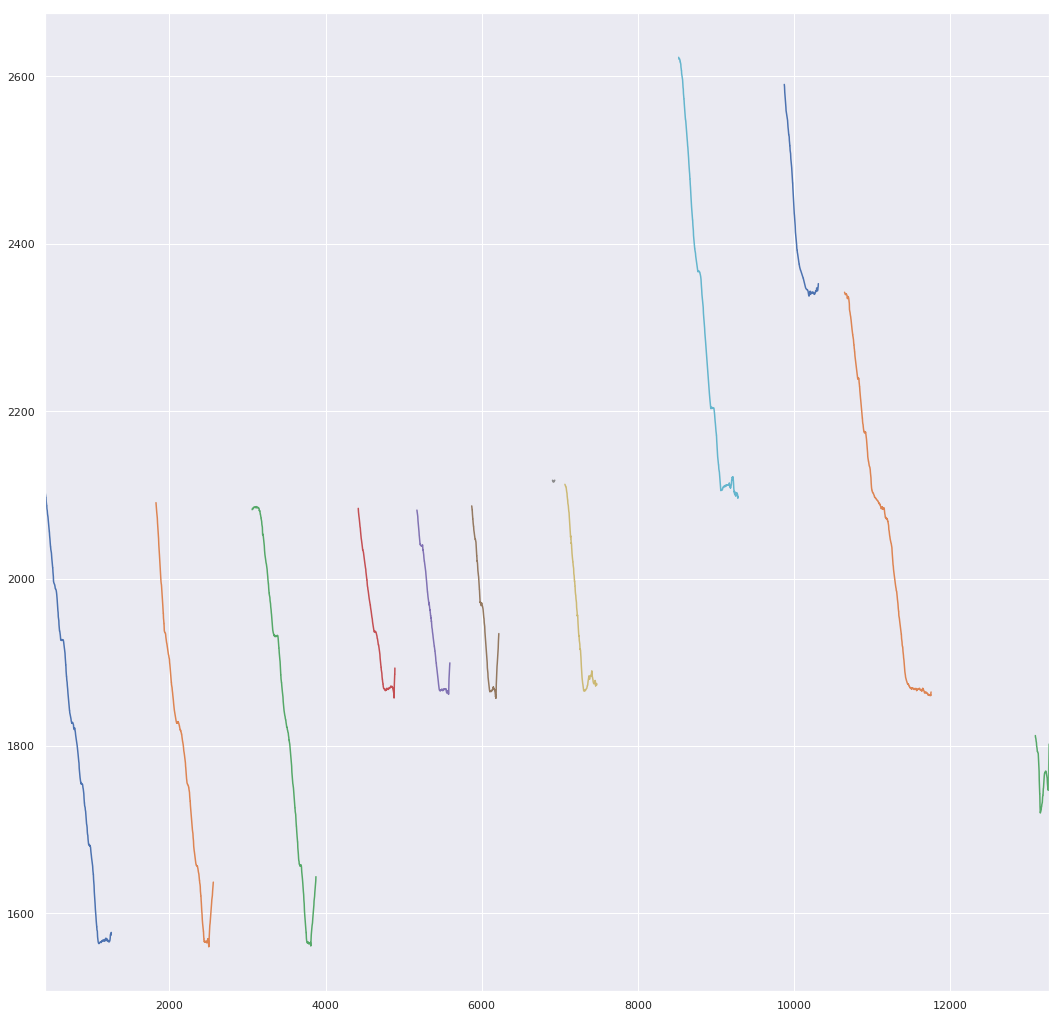

In [44]:
fig, axes= plt.subplots(1,1, figsize=(18,18))
#axes = axes.reshape(1,-1)[0]
for i in range(num_runs):
    start  =np.int(runs.loc[i].start_idx)
    end =  np.int(runs.loc[i].end_idx)
    #print(start, end)
    data.loc[start:end,('GPS_Alt')].plot(ax=axes)

/home/jjc/miniconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=6725.0, right=6725.0
  ax.set_xlim(left, right)


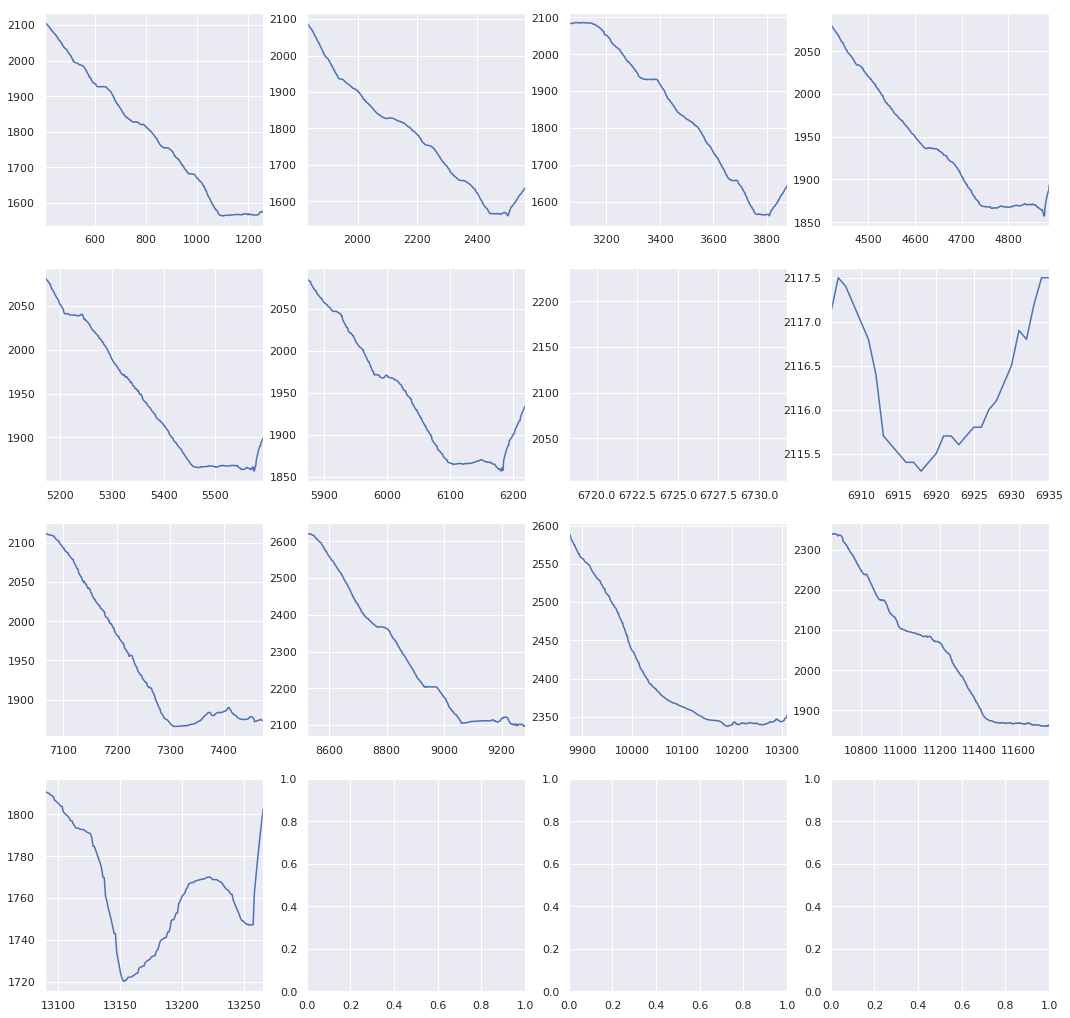

In [45]:
fig, axes= plt.subplots(4, 4, figsize=(18,18))
axes = axes.reshape(1,-1)[0]
for i in range(num_runs):
    start  =np.int(runs.loc[i].start_idx)
    end =  np.int(runs.loc[i].end_idx)
    #print(start, end)
    data.loc[start:end,('GPS_Alt')].plot(ax=axes[i])

In [46]:
import gpxpy.gpx

In [47]:
def save_gpx_run(data, runs, name, date):
    
    gpx = gpxpy.gpx.GPX()
    # Create first track in our GPX:
    gpx_track = gpxpy.gpx.GPXTrack()
    gpx.tracks.append(gpx_track)
    
    num_runs = runs.shape[0]
    
    for i in range(num_runs):
        print(i)
        gpx_segment = gpxpy.gpx.GPXTrackSegment()
        gpx_track.segments.append(gpx_segment)
        
        start  =np.int(runs.loc[i].start_idx)
        end =  np.int(runs.loc[i].end_idx)
        #print(start, end)
        run_data = data.loc[start:end].copy()
        
        points = run_data[['Lat','Lon','GPS_Alt']].values

        #create points
        for point in points:
            gpx_segment.points.append(gpxpy.gpx.GPXTrackPoint(point[0],point[1], elevation=point[2]))
    
    xml = gpx.to_xml()
    
    #filename = '{}_{}_{}.xml'.format(name,date.strftime('%d%b%y'),i)
    filename = '{}_{}_runs.xml'.format(name,date.strftime('%d%b%y'))
    print(filename)
    with open('gpx_files/'+filename,'w') as f:
        f.write(xml)

In [48]:
save_gpx_run(data,runs,name, date)

0
1
2
3
4
5
6
7
8
9
10
11
12
josh_17Mar19_runs.xml


In [49]:
def save_json_run(data, runs, name, date):
    
    num_runs = runs.shape[0]
    
    for i in range(num_runs):
        print(i)
        
        start  =np.int(runs.loc[i].start_idx)
        end =  np.int(runs.loc[i].end_idx)
        run_data = data.loc[start:end].copy()
        
        values=run_data[['Lat','Lon','GPS_Alt']].copy()
        values.rename(columns={'Lat':'x','Lon':'y','GPS_Alt':'z'},inplace=True)
    
        json_values = values.to_dict(orient='records')
    
        filename = '{}_{}_{}.json'.format(name,date.strftime('%d%b%y'),i)
        print(filename)
        with open('json_files/'+filename,'w') as f:
            json.dump(json_values,f)
        

In [50]:
save_json_run(data,runs,name, date)

0
josh_17Mar19_0.json
1
josh_17Mar19_1.json
2
josh_17Mar19_2.json
3
josh_17Mar19_3.json
4
josh_17Mar19_4.json
5
josh_17Mar19_5.json
6
josh_17Mar19_6.json
7
josh_17Mar19_7.json
8
josh_17Mar19_8.json
9
josh_17Mar19_9.json
10
josh_17Mar19_10.json
11
josh_17Mar19_11.json
12
josh_17Mar19_12.json
